# Tutorial 2: Validating the Unwindowed $P_\ell(k)$ Estimators

In this tutorial we will validate the PolyBin3D unwindowed estimators. For this purpose, we'll generate some fake data with and without a mask, and verify that the unwindowed power spectra match those from unmasked data.

### Preliminaries

We start by importing the packages we'll need, as well as defining some useful plotting functions.

In [64]:
%pylab inline
import os, sys
from nbodykit.lab import * # for various utility functions
import PolyBin3D as pb # the main code

def plotter(mat,axis=2,shift=True,vmax=None,title=''):
    """General purpose function for plotting a 3D density field, averaging over a specified axis. 
    
    We optionally apply an FFTshift operation, and truncate the plot to some symmetric range of values: [-vmax, vmax].
    """
    plt.figure()
    if shift:
        plot_mat = np.fft.fftshift(mat)
    else:
        plot_mat = mat
    to_plot = plot_mat.real.mean(axis=axis)
    if vmax is None:
        vmax = np.max(np.abs(to_plot))
    if len(title)>0:
        plt.title(title)
    plt.imshow(to_plot,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.show();
    
def plot_corr(f, v=1, subtract_identity=True, title=''):
    """Plot a correlation matrix, optionally subtracting the identity."""
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    if len(title)>0:
        plt.title(title)
    plt.imshow(cfish-subtract_identity*np.eye(len(cfish)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
    plt.colorbar();
    
    plt.hlines(pspec.Nk-0.5, 0, 2*pspec.Nk, linestyles='--',alpha=0.5)
    plt.vlines(pspec.Nk-0.5, 0, 2*pspec.Nk, linestyles='--',alpha=0.5)
    plt.xlim(-0.5,2*pspec.Nk-0.5)
    plt.ylim(2*pspec.Nk-0.5,-0.5)
    plt.xlabel('Bin Index 1',fontsize=12)
    plt.ylabel('Bin Index 2',fontsize=12)

Populating the interactive namespace from numpy and matplotlib


### 1. Set-up

First, we'll generate some mock data. The idea will be to generate data that we exactly know the power spectrum of, so we can test if we exactly recover it. For this reason, we'll use a global line-of-sight (including anisotropy) and generate redshift-space multipoles with $\ell\in\{0,2\}$. We'll additionally cut out any modes outside the $k$-range we're interested in to avoid any residual leakage (induced by the mask).

First, we load a mask and associated attributes. This is adapted from the BOSS DR12 LOWZ-SGC survey data and contains significant anisotropy and power across a broad range of scales.

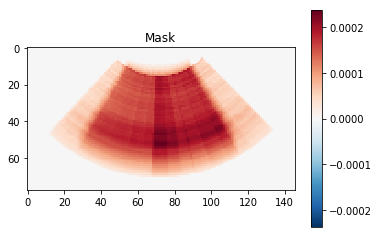

In [2]:
with np.load('sample_mask.npz') as d:
    mask_grid = d['mask']
    gridsize = d['gridsize']
    boxsize = d['boxsize']
nbar = np.average(mask_grid, weights=mask_grid!=0)
    
plotter(mask_grid, title='Mask')

Next, we create a fiducial set of power spectrum multipoles (assuming the Kaiser formula).

In [3]:
# Define fiducial power spectrum (assuming the Kaiser formula)
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)
redshift = 0.55
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)

# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.0001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

We'll also create a function to generate a Gaussian Random Field dataset, either with or without the mask. This uses a global line-of-sight of anisotropy along the $z$-axis. It optionally includes the survey geometry. We'll add a TSC pixel-window function to the data (added after the mask, emulating real data).

For this, we'll use the ``generate_data()`` function available in the PolyBin3D base class.  


# Dimensions: [1.01e+03, 1.91e+03, 1.06e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [78, 146, 82]
# Fundamental frequency: [0.006, 0.003, 0.006] h/Mpc
# Nyquist frequency: [0.243, 0.240, 0.243] h/Mpc
# Pixel window: interlaced-tsc


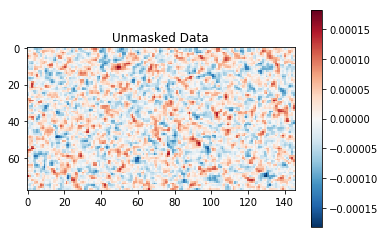

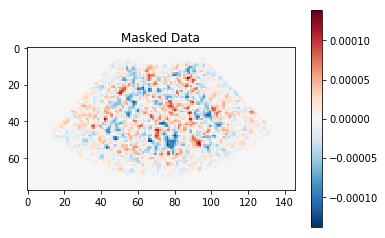

In [4]:
## Load base class
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs ('fftw' for cpu, 'jax' for gpu)
                 nthreads=4, # number of CPUs for performing FFTs (only applies to 'fftw' backend)
                 sightline='global', # line-of-sight [global = z-axis, local = relative to pair]
                )

# Define k-min and k-max
k_min = 0.01
k_max = 0.20
bin_filt = (k_arr>=k_min)&(k_arr<k_max)

def create_data(seed, apply_mask=False):
    """Create a Gaussian random field dataset, optionally with a mask"""
    
    # Generate GRF data
    density_grf = base.generate_data(seed, Pk_input=[k_arr,P0_arr*bin_filt,P2_arr*bin_filt])
    
    # Optionally apply the mask
    if apply_mask:
        
        # Remove pixelation window
        depixeled_density = base.to_real(base.to_fourier(density_grf)/base.pixel_window_grid)
    
        # Add mask and replace pixelation window
        masked_density = base.to_real(base.pixel_window_grid*base.to_fourier(mask_grid*depixeled_density))
    
    else:
        masked_density = density_grf.copy()*nbar
        
    return masked_density

# Plot a dataset
plotter(create_data(42, apply_mask=False), title='Unmasked Data')
plotter(create_data(42, apply_mask=True), title='Masked Data')

### 2. Compute Power Spectra of *Unmasked* Data 

We now compute the power spectrum of the unmasked data using PolyBin3D. To do this,  we'll load the power spectrum class and compute spectra using ``Pk_ideal``. We'll iterate over a bunch of simulations to minimize the errorbars.

In [13]:
# Define some k-bins and ell_max
k_edges = np.arange(k_min, k_max+1e-3, 0.01)
lmax = 2

# Load the power spectrum class with uniform mask
pspec = pb.PSpec(base, k_edges, applySinv = None, mask = nbar, lmax = lmax, odd_l = False)

# Define the k-bin centers
k_cen = pspec.get_ks()

Pks_unmasked = []
N_sim = 250
for sim in range(N_sim):
    if (sim+1)%5==0: print("Iteration %d of %d"%(sim+1,N_sim))

    # Generate GRF
    density_grf = create_data(sim, apply_mask=False)

    # Compute power spectrum
    Pks_unmasked.append(pspec.Pk_ideal(density_grf))
    
# Cleanup
def _compute_mean_std(Ps):
    Pk_mean = {key: np.mean([P[key] for P in Ps],axis=0) for key in ['p0','p2']}
    Pk_std = {key: np.std([P[key] for P in Ps],axis=0) for key in ['p0','p2']}
    return {'mean':Pk_mean, 'std':Pk_std}

Pk_unmasked = _compute_mean_std(Pks_unmasked)


Binning: 19 bins in [0.010, 0.200] h/Mpc
l-max: 2
Mask: constant
Computing ideal Fisher matrix
Iteration 5 of 250
Iteration 10 of 250
Iteration 15 of 250
Iteration 20 of 250
Iteration 25 of 250
Iteration 30 of 250
Iteration 35 of 250
Iteration 40 of 250
Iteration 45 of 250
Iteration 50 of 250
Iteration 55 of 250
Iteration 60 of 250
Iteration 65 of 250
Iteration 70 of 250
Iteration 75 of 250
Iteration 80 of 250
Iteration 85 of 250
Iteration 90 of 250
Iteration 95 of 250
Iteration 100 of 250
Iteration 105 of 250
Iteration 110 of 250
Iteration 115 of 250
Iteration 120 of 250
Iteration 125 of 250
Iteration 130 of 250
Iteration 135 of 250
Iteration 140 of 250
Iteration 145 of 250
Iteration 150 of 250
Iteration 155 of 250
Iteration 160 of 250
Iteration 165 of 250
Iteration 170 of 250
Iteration 175 of 250
Iteration 180 of 250
Iteration 185 of 250
Iteration 190 of 250
Iteration 195 of 250
Iteration 200 of 250
Iteration 205 of 250
Iteration 210 of 250
Iteration 215 of 250
Iteration 220 of 250


Let's plot the results. The output power spectra look consistent with the input theory, as expected! (Note that the errorbars are the error in a *single* realization, so remain large even though we used many simulations).

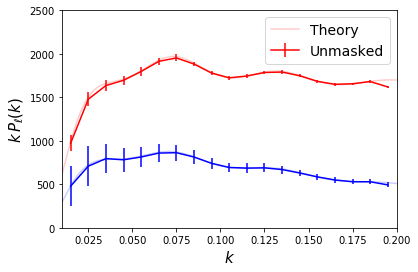

In [14]:
cs = ['r','b']
plt.plot(k_arr, k_arr*P0_arr,c='r',alpha=0.2, label='Theory')
plt.plot(k_arr, k_arr*P2_arr,c='b',alpha=0.2)
for l in [0,2]:
    plt.errorbar(k_cen, k_cen*Pk_unmasked['mean']['p%d'%l], yerr=k_cen*Pk_unmasked['std']['p%d'%l],c=cs[l//2], label='Unmasked')
    if l==0: plt.legend(fontsize=14);
plt.xlim(min(k_edges),max(k_edges))
plt.ylim(0,2500);
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);

### 3. Compute Power Spectra of *Masked* Data 

We now compute the power spectrum of the masked data now using the ``Pk_unwindowed`` routine. Before doing so, we'll decide on a weighting scheme, and compute the Fisher matrix. Here, we'll use a simple FKP-like weighting $$\mathsf{S}^{-1}(\vec x, \vec y) = \frac{\delta_{\rm D}(\vec x-\vec y)}{n(\vec x)P_{\rm FKP}+1}.$$

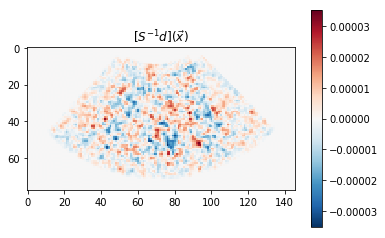

In [15]:
# Define a real-space FKP weight
P_fkp = 1e4
fkp_weight = 1./(mask_grid*P_fkp+1)

def applySinv_fkp(input_data, input_type='real', output_type='real'):
    """Apply an FKP-like filter to the data."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data)
    else:
        input_real = input_data.copy()
    
    # Apply FKP weight
    output_real = input_real*fkp_weight
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

# Test the function
plotter(applySinv_fkp(create_data(42, apply_mask=True)), title=r'$[S^{-1} d](\vec x)$');

Below we compute the Fisher matrix using Monte Carlo realizations. Using more realizations will reduce the Monte Carlo noise (with the variance scaling as $1/N_{\rm it}$) which can lead to bias in the unwindowed estimators.

In [16]:
# Load the power spectrum class with our S^-1 function and the non-uniform mask
pspec = pb.PSpec(base, k_edges, applySinv = applySinv_fkp, mask = mask_grid, lmax = lmax, odd_l = False)

# Number of Monte Carlo iterations
N_it = 50

# Iterate over realizations
fish_and_shot = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot.append(pspec.compute_fisher_contribution(s,verb=(s==0)))

# Clean-up output
fish = np.mean([f[0] for f in fish_and_shot],axis=0)
shot_num = np.mean([f[1] for f in fish_and_shot],axis=0)

# # Alternative:
# fish, shot_num = pspec.compute_fisher(N_it, 1, False)


Binning: 19 bins in [0.010, 0.200] h/Mpc
l-max: 2
Mask: spatially varying
Computing iteration 1 of 50
Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

Computing iteration 2 of 50
Computing iteration 3 of 50
Computing iteration 4 of 50
Computing iteration 5 of 50
Computing iteration 6 of 50
Computing iteration 7 of 50
Computing iteration 8 of 50
Computing iteration 9 of 50
Computing iteration 10 of 50
Computing iteration 11 of 50
Computing iteration 12 of 50
Computing iteration 13 of 50
Computing iteration 14 of 50
Computing iteration 15 of 50
Computing iteration 16 of 50
Computing iteration 17 of 50
Computing iteration 18 of 50
Computing iteration 19 of 50
Computing iteration 20 of 50
Computing iteration 21 of 50
Computing iteration 22 of 50
Computing iteration 23 of 50
Computing iteration 24 of 50
Computing iteration 25 of 50
Computing iteration 26 of 50
Computing iteration 27 of 50
Computing iteration 28 of 50


Now we compute the power spectrum, folding in the Fisher matrix we just computed. To assess the impact of the window function on our data, we'll also compute the *window-convolved* spectra using the ``Pk_ideal`` routine.

In [17]:
Pks_masked_ideal = []
Pks_masked_unwindowed = []
for sim in range(N_sim):
    if (sim+1)%5==0: print("Iteration %d of %d"%(sim+1,N_sim))

    # Generate GRF
    density_grf = create_data(sim, apply_mask=True)

    # Compute ideal power spectrum
    Pks_masked_ideal.append(pspec.Pk_ideal(density_grf))
    
    # Compute unwindowed power spectrum
    Pks_masked_unwindowed.append(pspec.Pk_unwindowed(density_grf, fish=fish, shot_num=shot_num, subtract_shotnoise=False))

# Cleanup
Pk_masked_ideal = _compute_mean_std(Pks_masked_ideal)
Pk_masked_unwindowed = _compute_mean_std(Pks_masked_unwindowed)

Computing ideal Fisher matrix
Iteration 5 of 250
Iteration 10 of 250
Iteration 15 of 250
Iteration 20 of 250
Iteration 25 of 250
Iteration 30 of 250
Iteration 35 of 250
Iteration 40 of 250
Iteration 45 of 250
Iteration 50 of 250
Iteration 55 of 250
Iteration 60 of 250
Iteration 65 of 250
Iteration 70 of 250
Iteration 75 of 250
Iteration 80 of 250
Iteration 85 of 250
Iteration 90 of 250
Iteration 95 of 250
Iteration 100 of 250
Iteration 105 of 250
Iteration 110 of 250
Iteration 115 of 250
Iteration 120 of 250
Iteration 125 of 250
Iteration 130 of 250
Iteration 135 of 250
Iteration 140 of 250
Iteration 145 of 250
Iteration 150 of 250
Iteration 155 of 250
Iteration 160 of 250
Iteration 165 of 250
Iteration 170 of 250
Iteration 175 of 250
Iteration 180 of 250
Iteration 185 of 250
Iteration 190 of 250
Iteration 195 of 250
Iteration 200 of 250
Iteration 205 of 250
Iteration 210 of 250
Iteration 215 of 250
Iteration 220 of 250
Iteration 225 of 250
Iteration 230 of 250
Iteration 235 of 250
Ite

Let's plot the results! 

Below, we compare the power spectra computed using the unmasked data (black) to those from the masked data with the ideal (dark colors and points) and de-windowed (light colors and crosses) estimators. Notably, there are significant distortions induced by the mask, such that the ideal spectra do *not* match the masked spectra (particularly on large scales). However, the de-windowed estimators perform very well and closely match the truth! There's some slight residual distortions, but they can be removed by using more Monte Carlo simulations to estimate the Fisher matrix.

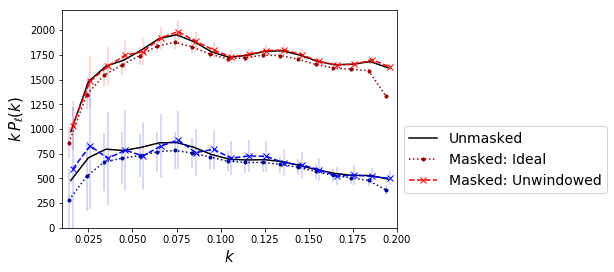

In [18]:
cs = ['r','b']
cs2 = ['darkred','darkblue']
dk = k_cen[1]-k_cen[0]
for l in [0,2]:
    plt.errorbar(k_cen, k_cen*Pk_unmasked['mean']['p%d'%l],
                 alpha=1.,c='k', label='Unmasked')
    plt.errorbar(k_cen-dk/10, k_cen*Pk_masked_ideal['mean']['p%d'%l],
                 c=cs2[l//2], ls=':',label='Masked: Ideal',marker='.')
    plt.errorbar(k_cen-dk/10, k_cen*Pk_masked_ideal['mean']['p%d'%l], 
                 yerr=k_cen*Pk_masked_ideal['std']['p%d'%l],
                 c=cs2[l//2], ls='', marker='',alpha=0.2)
    plt.errorbar(k_cen+dk/10, k_cen*Pk_masked_unwindowed['mean']['p%d'%l], 
                 c=cs[l//2], ls='--',label='Masked: Unwindowed',marker='x')
    plt.errorbar(k_cen+dk/10, k_cen*Pk_masked_unwindowed['mean']['p%d'%l], 
                 yerr=k_cen*Pk_masked_unwindowed['std']['p%d'%l],
                 c=cs[l//2], ls='', marker='',alpha=0.2)
    if l==0: plt.legend(fontsize=14,bbox_to_anchor=(1.,0.5));
plt.xlim(min(k_edges),max(k_edges))
plt.ylim(0,2200);
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);

Let's also compare the variances. The masked spectra have significantly higher variances; this is expected since the mask removes much of the data. We also find that the ideal spectra appear to have lower variance than the unwindowed spectra? This occurs due to the differences in correlation structure; unwindowed spectra have significant anti-correlations between neighboring bins.

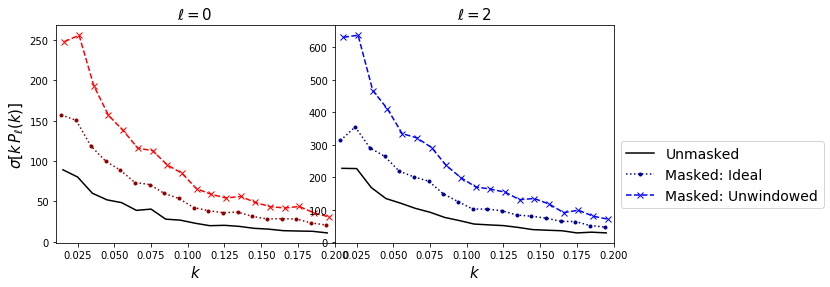

In [46]:
cs = ['r','b']
cs2 = ['darkred','darkblue']
dk = k_cen[1]-k_cen[0]
fig,ax = plt.subplots(1,2,figsize=(10,4),sharex=True)
plt.subplots_adjust(wspace=0)
for l in [0,2]:
    ax[l//2].plot(k_cen, k_cen*Pk_unmasked['std']['p%d'%l],
             alpha=1.,c='k', label='Unmasked')
    ax[l//2].plot(k_cen-dk/10, k_cen*Pk_masked_ideal['std']['p%d'%l],
                 c=cs2[l//2], ls=':',label='Masked: Ideal',marker='.')
    ax[l//2].plot(k_cen+dk/10, k_cen*Pk_masked_unwindowed['std']['p%d'%l], 
                 c=cs[l//2], ls='--',label='Masked: Unwindowed',marker='x')
    ax[l//2].set_xlim(min(k_edges),max(k_edges))
    ax[l//2].set_xlabel(r'$k$',fontsize=15)
    ax[l//2].set_title(r'$\ell=%d$'%l,fontsize=15)
ax[0].set_ylabel(r'$\sigma[k\,P_\ell(k)]$',fontsize=15);
ax[1].legend(fontsize=14,bbox_to_anchor=(1.,0.5));    

Let's also compare the covariances. We find that the unmasked spectra are approximately uncorrelated except for correlations between $\ell=0$ and $\ell=2$ (induced by redshift-space distortions). When the mask is included, there's off-diagonal correlations between neighboring bins in the ideal (FKP) estimators. For the unwindowed estimators, we find *anti-correlations*; this occurs since $\mathcal{F}^{-1/2}\hat{p}$ is approximately diagonal (for an ideal $\mathsf{S}^{-1}$ weighting).

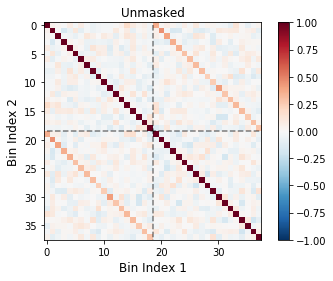

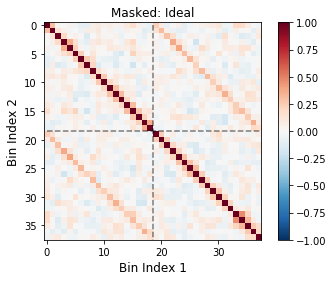

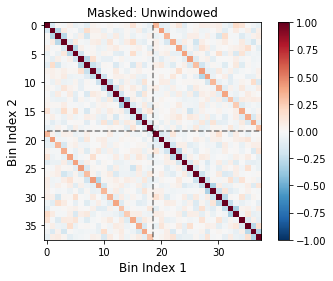

In [66]:
def compute_cov(Ps):
    """Compute the covariance matrix from a set of power spectra."""
    P_stack = np.asarray([np.concatenate([P['p0'],P['p2']]) for P in Ps])
    return np.cov(P_stack.T)

cov_unmasked = compute_cov(Pks_unmasked)
cov_masked_ideal = compute_cov(Pks_masked_ideal)
cov_masked_unwindowed = compute_cov(Pks_masked_unwindowed)

plot_corr(cov_unmasked, subtract_identity=0, title='Unmasked')
plot_corr(cov_masked_ideal, subtract_identity=0, title='Masked: Ideal')
plot_corr(cov_masked_unwindowed, subtract_identity=0, title='Masked: Unwindowed')

Finally, we'll test the optimality of the unwindowed estimators by computing the total signal-to-noise ratio of the power spectrum measurements. We find that the masked spectra have much lower signal-to-noise, which matches expectations since the mask leads to information loss. The unwindowed estimators have slightly higher signal-to-noise than the ideal estimators, as expected. This is despite the larger variances seen above, and occurs due to the anticorrelations between neighboring bins.

In [68]:
def compute_snr(Ps):
    """Compute the covariance matrix from a set of power spectra."""
    P_stack = np.asarray([np.concatenate([P['p0'],P['p2']]) for P in Ps])
    cov = np.cov(P_stack.T)
    icov = np.linalg.inv(cov)
    P_mean = np.mean(P_stack,axis=0)
    snr_sq = np.matmul(P_mean,np.matmul(icov, P_mean))
    return np.sqrt(snr_sq)

snr_unmasked = compute_snr(Pks_unmasked)
snr_masked_ideal = compute_snr(Pks_masked_ideal)
snr_masked_unwindowed = compute_snr(Pks_masked_unwindowed)
print("Unmasked SNR: %.0f"%snr_unmasked)
print("Masked SNR: %.0f (ideal) vs %.0f (unwindowed)"%(snr_masked_ideal,snr_masked_unwindowed))

Unmasked SNR: 428
Masked SNR: 157 (ideal) vs 177 (unwindowed)


This completes the tutorial! In the final power spectrum tutorial, we'll apply the unwindowed estimators to the BOSS DR12 dataset.